In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import numpy as np
import os,cv2

In [15]:
def plot_gallery(images,title,h,w,n_row=3,n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8*n_col,2.4*n_row))
    plt.subplots_adjust(bottom=0,left=.01,right=.99,top=.90,hspace=.35)
    for i in range(n_row*n_col):
        plt.subplot(n_row,n_col,i+1)
        plt.imshow(images[i].reshape((h,w)),cmap=plt.cm.gray)
        plt.title(title[i],size=12)
        plt.xticks(())
        plt.yticks(())

In [21]:
dir_name="dataset/faces/"
y=[];x=[];target_names=[]
person_id=0;h=w=300
n_samples=0
class_names=[]
for person_name in os.listdir(dir_name):
    dir_path=dir_name+person_name+"/"
    class_names.append(person_name)
    for image_name in os.listdir(dir_path):
        image_path=dir_path+image_name
        img=cv2.imread(image_path)
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        resized_image=cv2.resize(gray,(h,w))
        v=resized_image.flatten()
        x.append(v)
        n_samples=n_samples+1
        y.append(person_id)
        target_names.append(person_name)
    person_id=person_id+1 


###################################################
#transform list to numpy array
y=np.array(y)
x=np.array(x)
target_names=np.array(target_names)
n_features=x.shape[1]
print(y.shape,x.shape,target_names.shape)
print("Number of samples : ",n_samples)

n_classes=target_names.shape[0]

print("Total dataset size : ")
print("n_samples : %d" % n_samples)
print("n_features : %d" % n_features)
print("n_classes : %d" % n_classes)

(450,) (450, 90000) (450,)
Number of samples :  450
Total dataset size : 
n_samples : 450
n_features : 90000
n_classes : 450


Extraction the top 150 eigenfaces from 337 faces


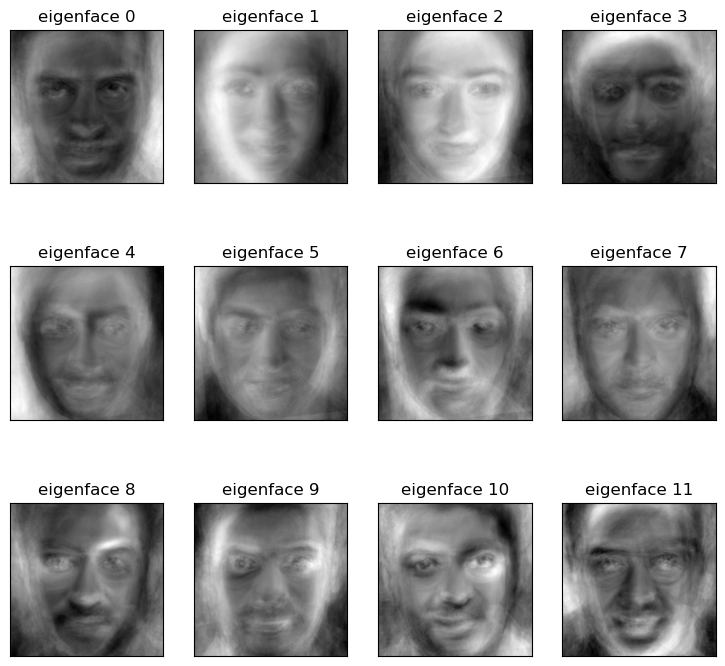

Projecting the input data on the eigenfaces orthonormal basis
(337, 150) (113, 150)
Project Done....


In [23]:
#split into training and test dataset
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

###################################################################################
#compute a PCA(eiganfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction
n_components=150

print("Extraction the top %d eigenfaces from %d faces"% (n_components,x_train.shape[0]))

#Applying PCA
pca=PCA(n_components=n_components,svd_solver='randomized',whiten=True).fit(x_train)

#Generating eigenfaces
eigenfaces=pca.components_.reshape((n_components,h,w))

#plot the galley of the most significative eigenfaces
eigenface_titles=["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces,eigenface_titles,h,w)

plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")
x_train_pca=pca.transform(x_train)
x_test_pca=pca.transform(x_test)
print(x_train_pca.shape,x_test_pca.shape)

# %%Compute Fisherfaces
lda=LinearDiscriminantAnalysis()
lda.fit(x_train_pca,y_train)

x_train_lda=lda.transform(x_train_pca)
x_test_lda=lda.transform(x_test_pca)
print("Project Done....")

In [25]:
#training with Multi layer perceptron
clf=MLPClassifier(random_state=1,hidden_layer_sizes=(10,10),max_iter=1000,verbose=True).fit(x_train_lda,y_train)
print("Model Weights : ")
model_info=[coef.shape for coef in clf.coefs_]
print(model_info)

Iteration 1, loss = 2.92888241
Iteration 2, loss = 2.88201880
Iteration 3, loss = 2.83799979
Iteration 4, loss = 2.79408322
Iteration 5, loss = 2.75177194
Iteration 6, loss = 2.71093672
Iteration 7, loss = 2.67050377
Iteration 8, loss = 2.63048408
Iteration 9, loss = 2.59289248
Iteration 10, loss = 2.55442199
Iteration 11, loss = 2.51861170
Iteration 12, loss = 2.48352066
Iteration 13, loss = 2.44897557
Iteration 14, loss = 2.41584465
Iteration 15, loss = 2.38222222
Iteration 16, loss = 2.35054891
Iteration 17, loss = 2.31931640
Iteration 18, loss = 2.28864987
Iteration 19, loss = 2.25811284
Iteration 20, loss = 2.22830681
Iteration 21, loss = 2.19983787
Iteration 22, loss = 2.17089040
Iteration 23, loss = 2.14408960
Iteration 24, loss = 2.11661652
Iteration 25, loss = 2.08932686
Iteration 26, loss = 2.06404278
Iteration 27, loss = 2.03798863
Iteration 28, loss = 2.01376253
Iteration 29, loss = 1.98887168
Iteration 30, loss = 1.96507186
Iteration 31, loss = 1.94107684
Iteration 32, los

Accuracy: 74.33628318584071


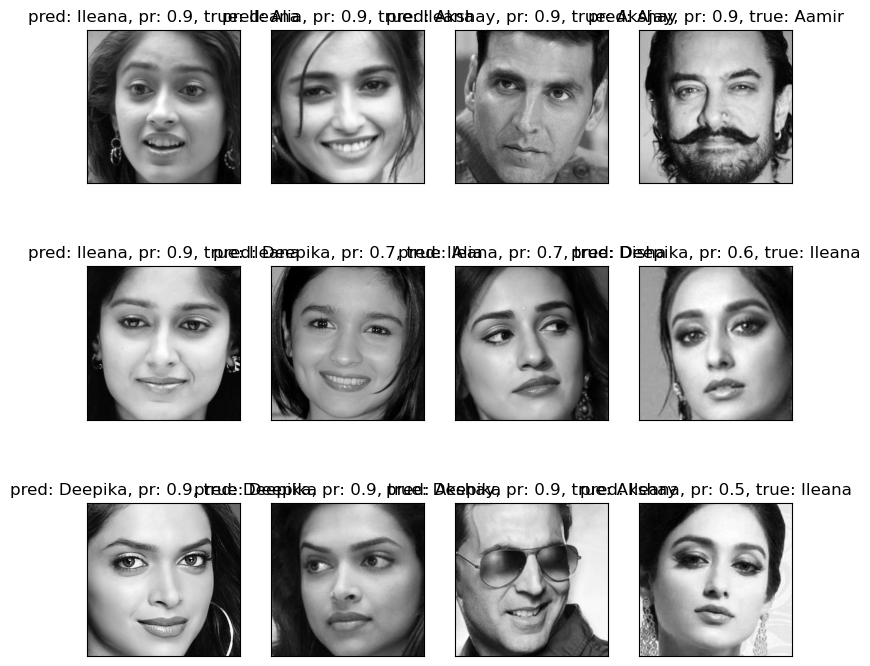

In [29]:
y_pred=[];y_prob=[]
for test_face in x_test_lda:
    prob = clf.predict_proba([test_face])[0]
    class_id=np.where(prob==np.max(prob))[0][0]
    y_pred.append(class_id)
    y_prob.append(np.max(prob))

#Transform the data
y_pred=np.array(y_pred)

prediction_titles=[]
true_positive=0
for i in range(y_pred.shape[0]):
    true_name=class_names[y_test[i]]
    pred_name=class_names[y_pred[i]]
    result = 'pred: %s, pr: %s, true: %s' % (pred_name, str(y_prob[i])[0:3], true_name)
    prediction_titles.append(result)
    if true_name==pred_name:
        true_positive=true_positive+1

print("Accuracy:",true_positive*100/y_pred.shape[0])

#Plot results
plot_gallery(x_test,prediction_titles,h,w)
plt.show()